# Skin Detection
### Bianchi Luca - 4805748

## Introduzione
La skin detection è una pratica utile in diversi ambiti, dall'automatizzare il processo di rilevamento di persone in flussi video al tracking del movimento di parti del corpo.

Come si può realizzare un metodo di skin detection? La sola analisi dei colori dell'immagine potrebbe non essere abbastanza, dato che sarebbe troppo suscettibile a variazioni delle condizioni di illuminazione, motivo per cui andremo ad utilizzare un metodo ibrido basato su:
- Analisi dei rapporti di colore (nello specifico R/G e R/B)
- Analisi di tinta e saturazione
- Analisi di crominanza

Caratteristiche che dovrebbero garantirci una maggiore solidità di fronte a cambiamenti ragionevoli di illuminazione

## Obiettivi
- Individuare segmenti di pelle nelle immagini
- Comprendere le criticità del task
- Definire alcuni possibili ambiti applicativi

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import warnings
warnings.filterwarnings('ignore')

In [17]:
FILE_DIR = './material/images'

## Metodi
### Normalized RGB

In [18]:
def normalized(rgb):
    norm=np.zeros_like(rgb,np.float32)
    r = rgb[:, :, 0]
    g = rgb[:, :, 1]
    b = rgb[:, :, 2]
    sum = rgb.sum(axis=2)
    norm[:,:,0]=r/sum
    norm[:,:,1]=g/sum
    norm[:,:,2]=b/sum
    return norm

In [19]:
def norm_analysis(img):
    img_array = np.asarray(img)
    img_array_norm = normalized(img_array)
    fig = plt.figure(figsize=(32, 8))
    plt.suptitle("Analisi immagine normalizzata")
    ax = plt.subplot(1, 4, 1)
    ax.title.set_text("Immagine normalizzata")
    plt.imshow(img_array_norm)
    plt.colorbar(orientation="vertical")
    mask_rg = cv.inRange(img_array_norm[:, :, 0]/img_array_norm[:,:,1], 1.14, 2.5)
    mask_rb = cv.inRange(img_array_norm[:, :, 0]/img_array_norm[:,:,2], 1.01, 100)
    mask_norm = mask_rg & mask_rb
    ax = plt.subplot(1, 4, 2)
    ax.title.set_text("Maschera su R'/G'")
    plt.imshow(mask_rg, cmap='gray')
    ax = plt.subplot(1, 4, 3)
    ax.title.set_text("Maschera su R'/B'")
    plt.imshow(mask_rb, cmap='gray')
    ax = plt.subplot(1, 4, 4)
    ax.title.set_text("Maschera combinata")
    plt.imshow(mask_norm, cmap='gray')
    return mask_norm

## HSV

In [20]:
def hsv_analysis(img):
    img_hsb = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    label = ["H", "S", "V"]
    cmaps = ["hsv", "Reds", "gray"]

    plt.figure(figsize=(32, 8))
    plt.suptitle("Analisi spazio HSV")
    ax = plt.subplot(1, 5, 1)
    ax.title.set_text("Immagine HSV")
    plt.imshow(img_hsb, cmap='hsv')

    for elem in range(img_hsb.shape[2]):
        plt.subplot(1, 5, elem + 2)
        plt.imshow(img_hsb[:, :, elem], cmap=cmaps[elem])
        plt.colorbar(orientation='vertical')
        plt.title(label[elem])
    mask_hsv = cv.inRange(img_hsb[:,:,0], 50, 160) & cv.inRange(img_hsb[:, :, 1], 15, 255)
    ax = plt.subplot(1, 5, 5)
    ax.title.set_text("Maschera")
    plt.imshow(mask_hsv, cmap="gray")
    return mask_hsv

## YCrCb

In [21]:
def ycbcr_analysis(img):
    img_ycbcr = cv.cvtColor(img, cv.COLOR_RGB2YCrCb)
    plt.figure(figsize=(32, 8))
    plt.suptitle("Analisi spazio YCbCr")
    ax = plt.subplot(1, 5, 1)
    ax.title.set_text("Immagine YCbCr")
    plt.imshow(img_ycbcr)
    ax = plt.subplot(1, 5, 2)
    ax.title.set_text("Luminanza")
    plt.imshow(img_ycbcr[:, : , 0], cmap='gray')
    plt.colorbar(orientation='vertical')
    ax = plt.subplot(1, 5, 3)
    ax.title.set_text("Crominanza blu")
    plt.imshow(img_ycbcr[:, :, 1], cmap='Blues')
    plt.colorbar(orientation='vertical')
    ax = plt.subplot(1, 5, 4)
    ax.title.set_text("Crominanza rosso")
    plt.imshow(img_ycbcr[:, :, 2], cmap='Reds')
    plt.colorbar(orientation='vertical')
    mask_ycrcb = cv.inRange(img_ycbcr[:, :, 1], 127, 187) & cv.inRange(img_ycbcr[:, :, 2], 73, 127)
    ax = plt.subplot(1, 5, 5)
    ax.title.set_text("Maschera")
    plt.imshow(mask_ycrcb, cmap="gray")
    return mask_ycrcb

## Combinato

In [22]:
def plot_masked(img, mask):
    plt.figure(figsize=(32, 8))
    plt.suptitle("Immagine mascherata")
    plt.imshow(cv.bitwise_or(img, img, mask=mask))

In [23]:
def run_analysis(img_name):
    img = np.asarray(plt.imread(FILE_DIR + img_name)).astype('uint8')
    plt.figure(figsize=(32, 8))
    plt.suptitle("Immagine originale")
    plt.imshow(img)

    mask = norm_analysis(img) & hsv_analysis(img) & ycbcr_analysis(img)
    plot_masked(img, mask)

## Analisi esperimenti

Cominciamo con l'analisi di un esperimento basilare, usando l'immagine di una mano su sfondo bianco

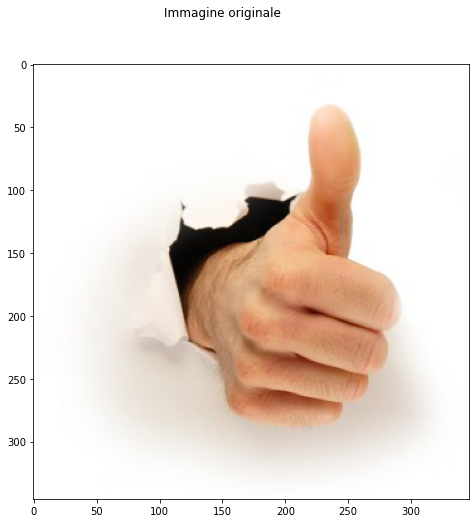

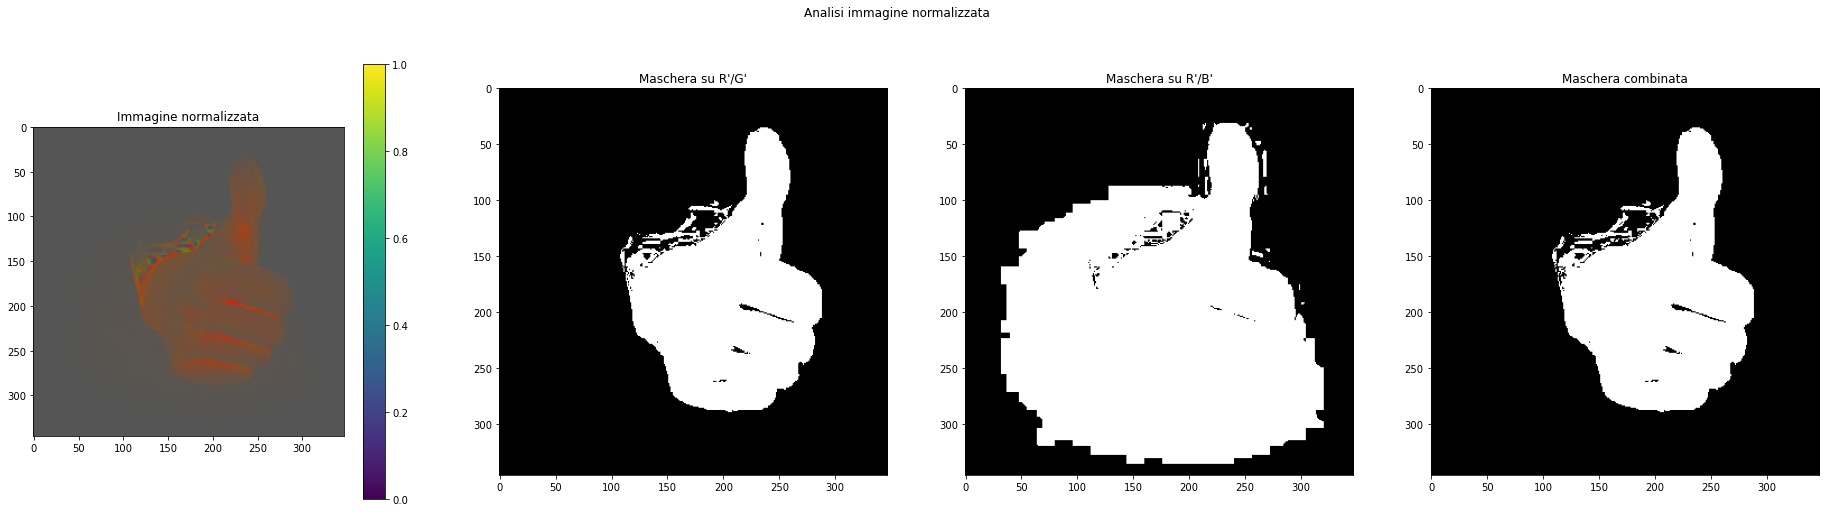

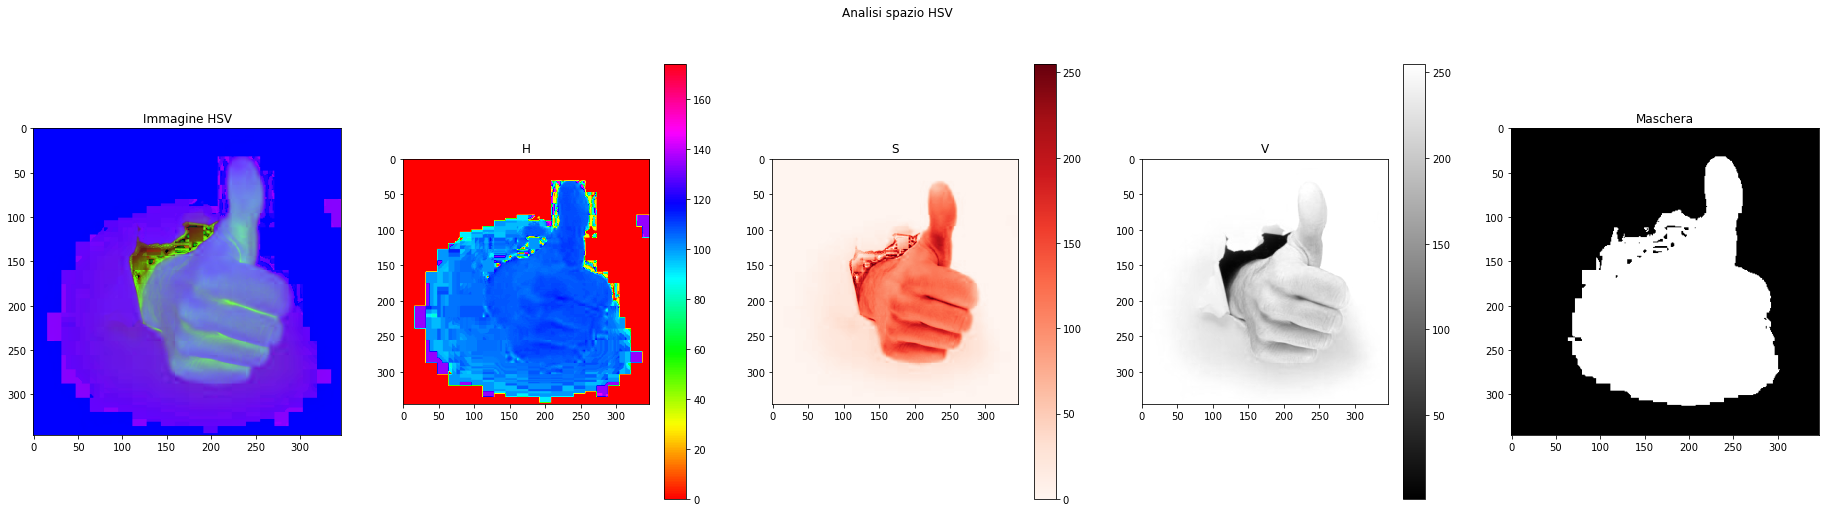

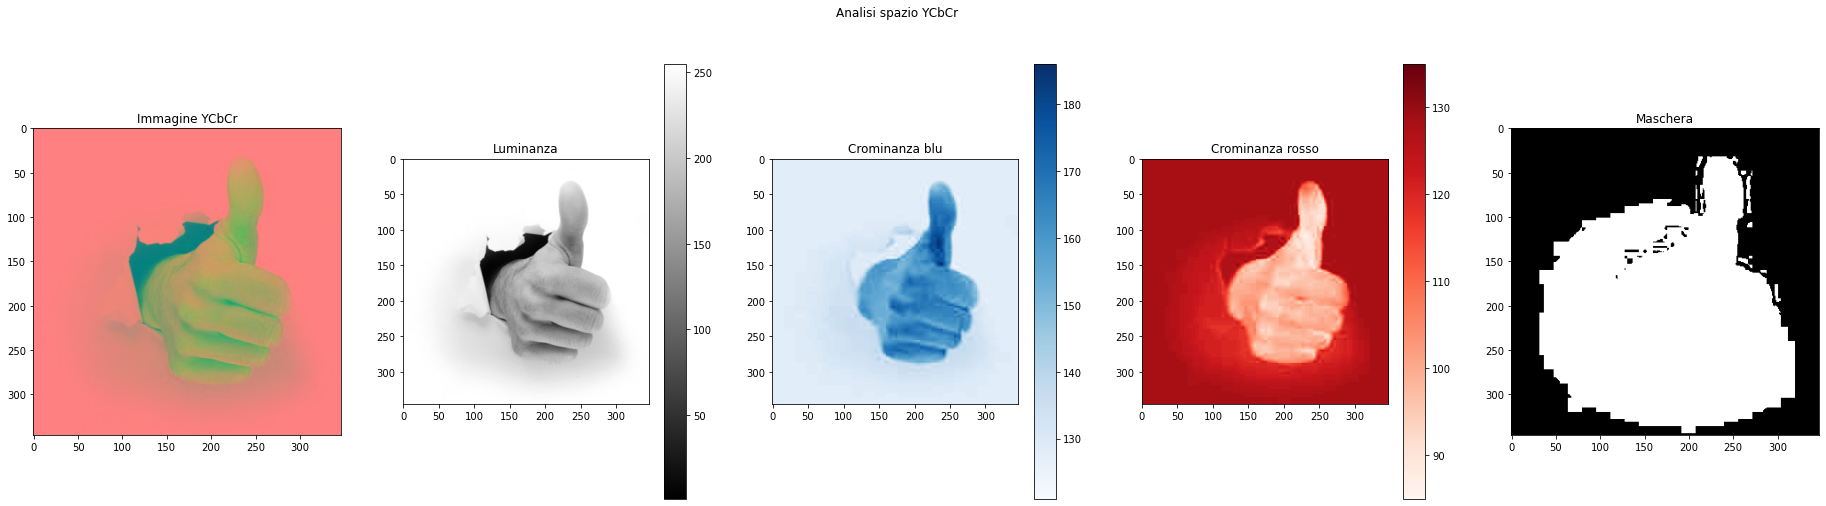

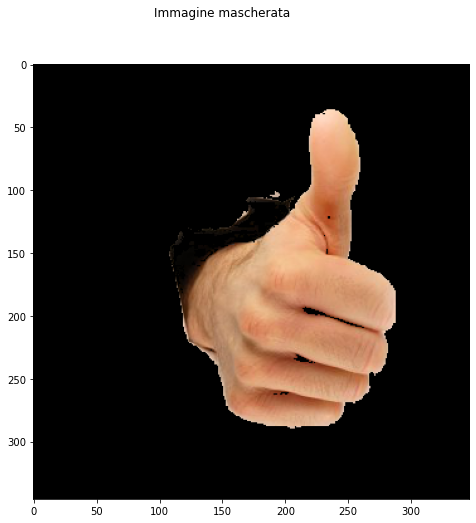

In [24]:
run_analysis("/pollicione.jpg")

Vediamo come, nonostante delle imperfezioni, dovute da una parte ad una saturazione troppo alta per i valori di soglia usati, e dall'altra ad un leggero riflesso dei colori della mano sul background che vanno a ingannare l'algoritmo, il risultato è quasi perfetto.
Ma passiamo ad un caso un po' più complesso, andando ad analizzare una foto catturata su una pista di atletica leggera.

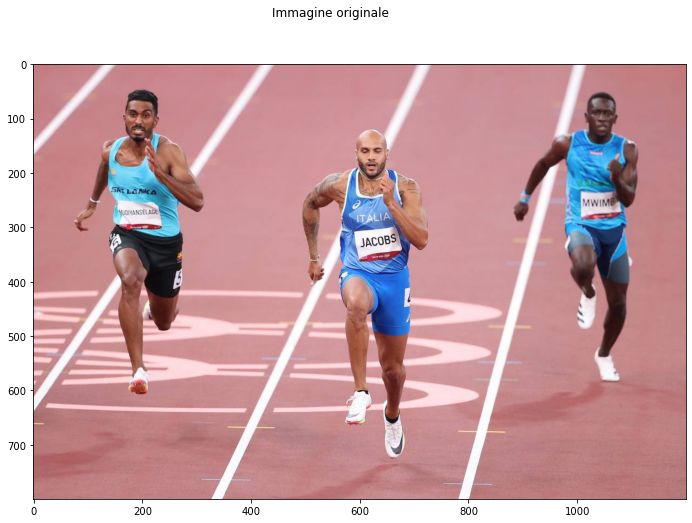

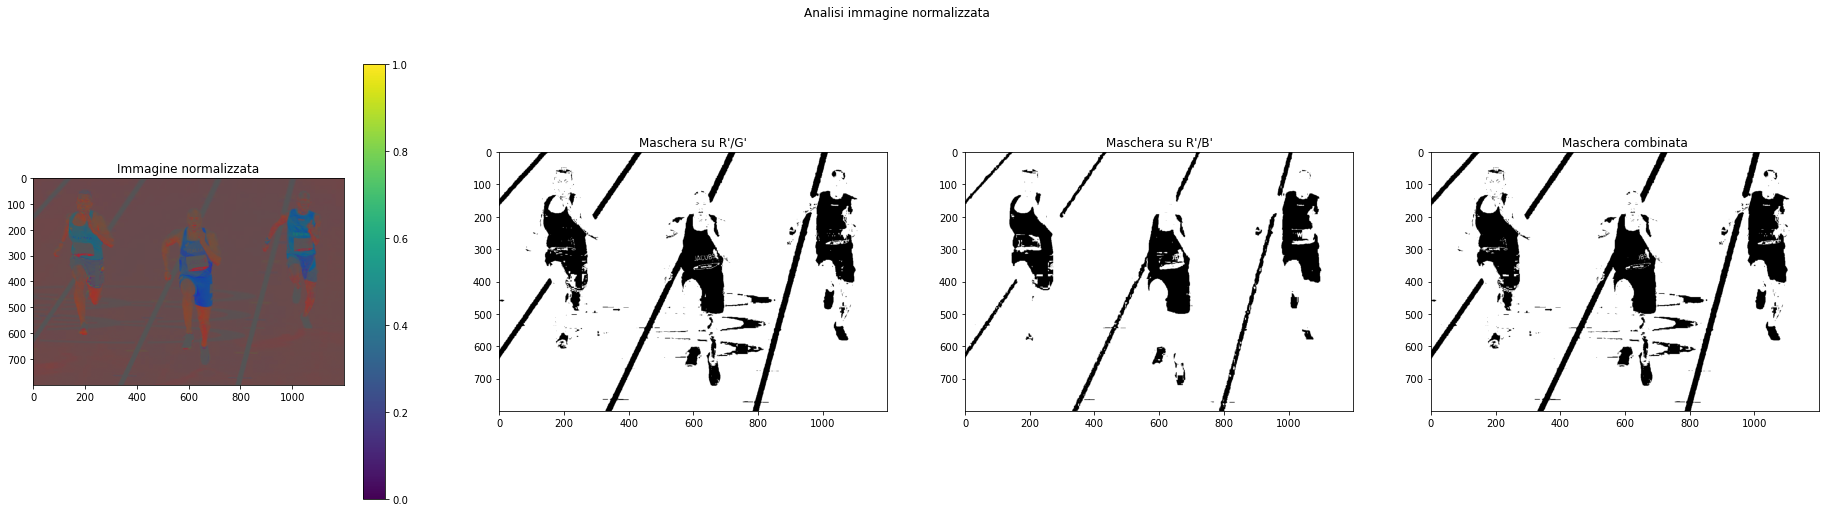

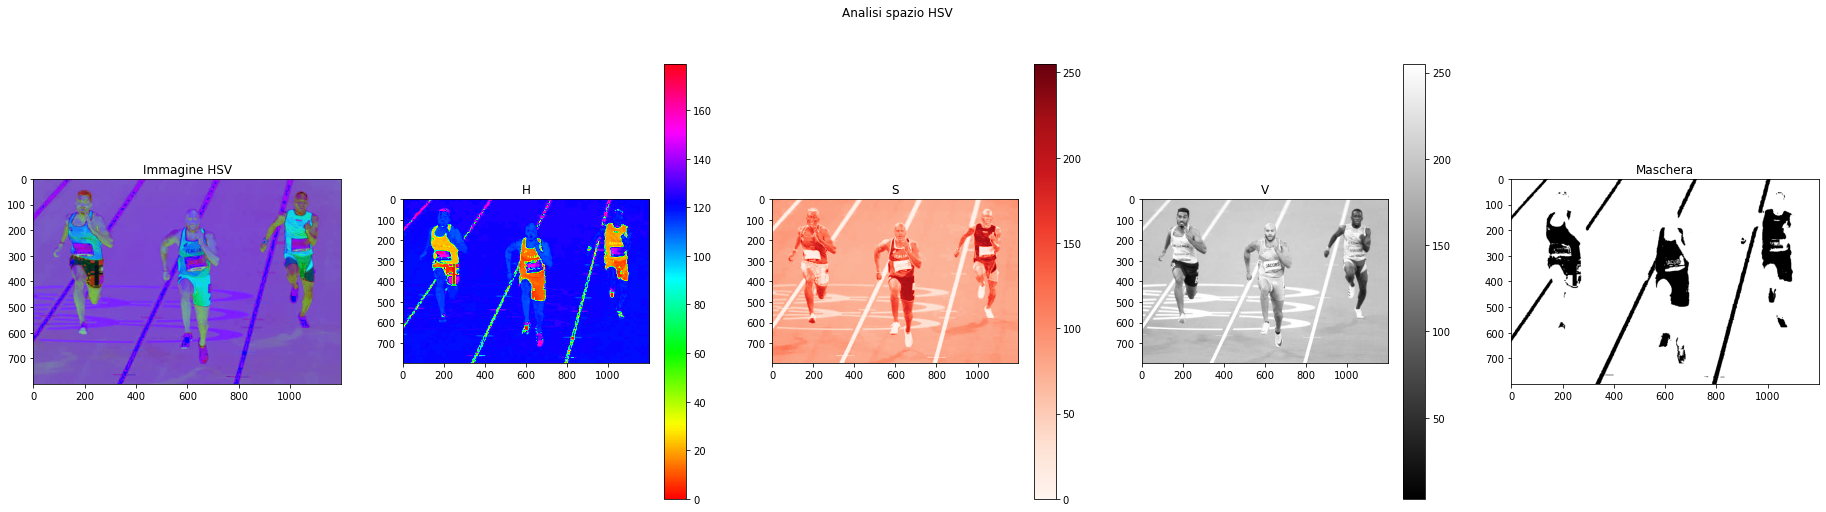

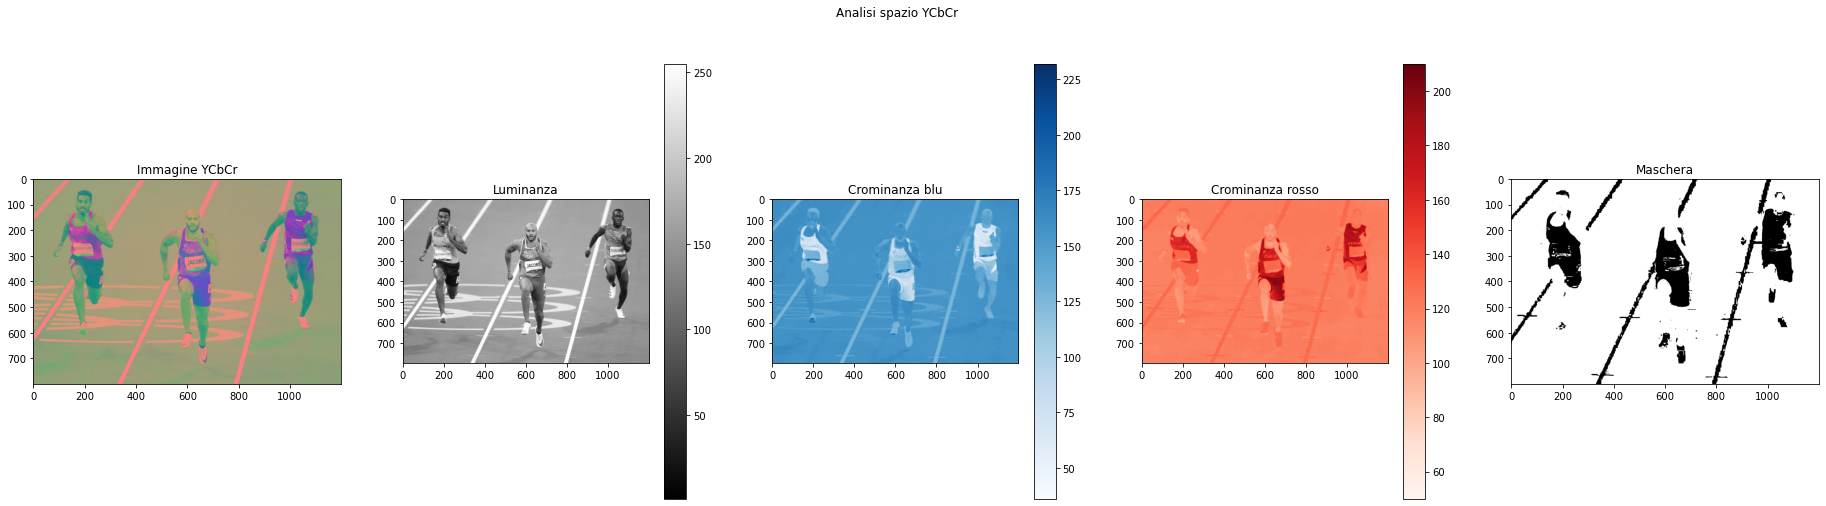

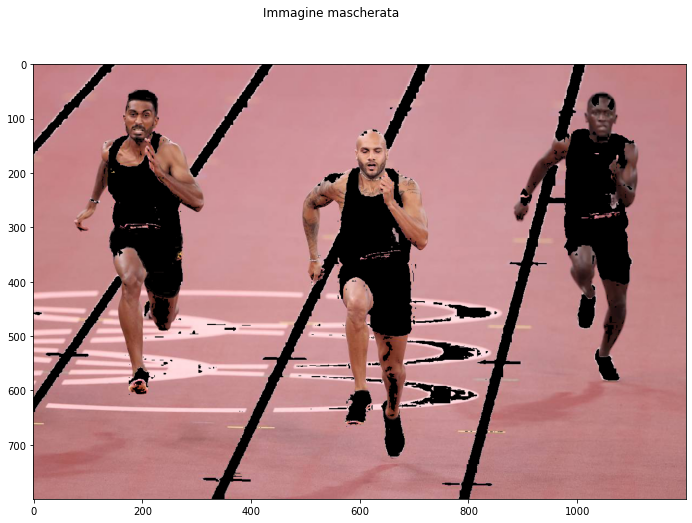

In [25]:
run_analysis("/jacobs.jpg")

Con le soglie impostate l'algoritmo rileva correttamente tutti i lembi di pelle presenti nella foto.
Ma, purtroppo, abbiamo uno sfondo che "emula" tutte le caratteristiche della pelle prese in considerazione e viene quindi inclusa come pelle.
Il problema non sarebbe nemmeno risolvibile modificando le soglie per le caratteristiche prese in analisi, dato che i valori legati al background non si trovano agli estremi del range di sogliatura, bensì nel mezzo. Vanno quindi considerate tecniche alternative per ottenere un risultato più corretto.

Proviamo ora ad analizzare un'immagine con problemi di illuminazione

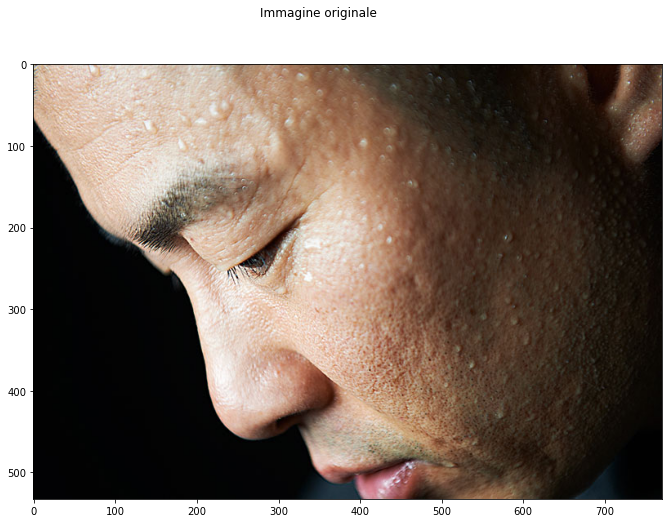

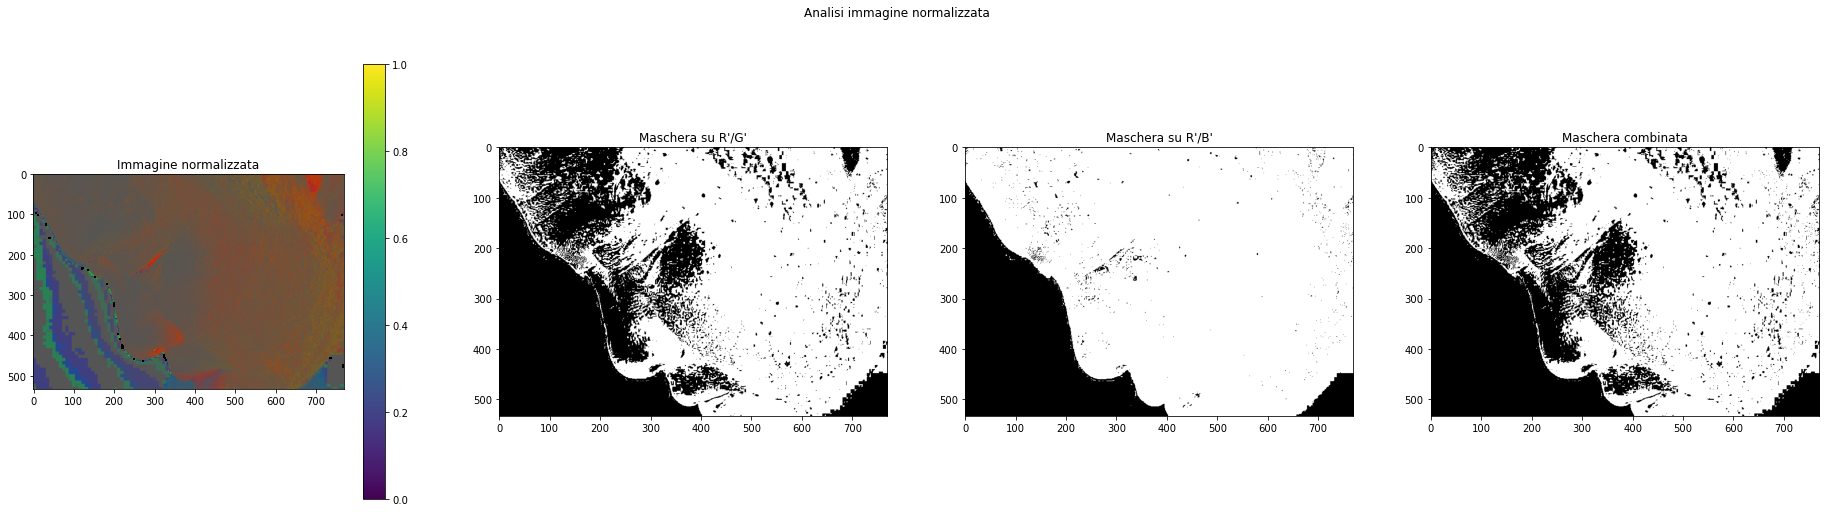

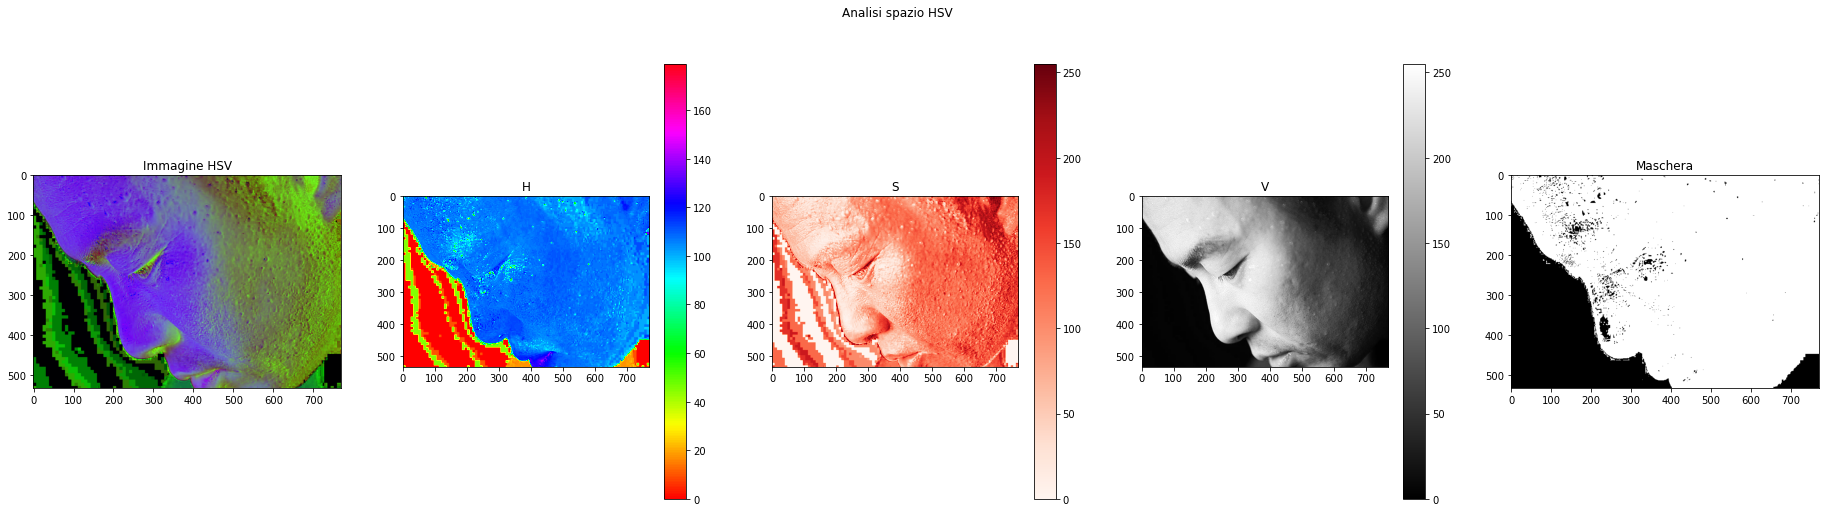

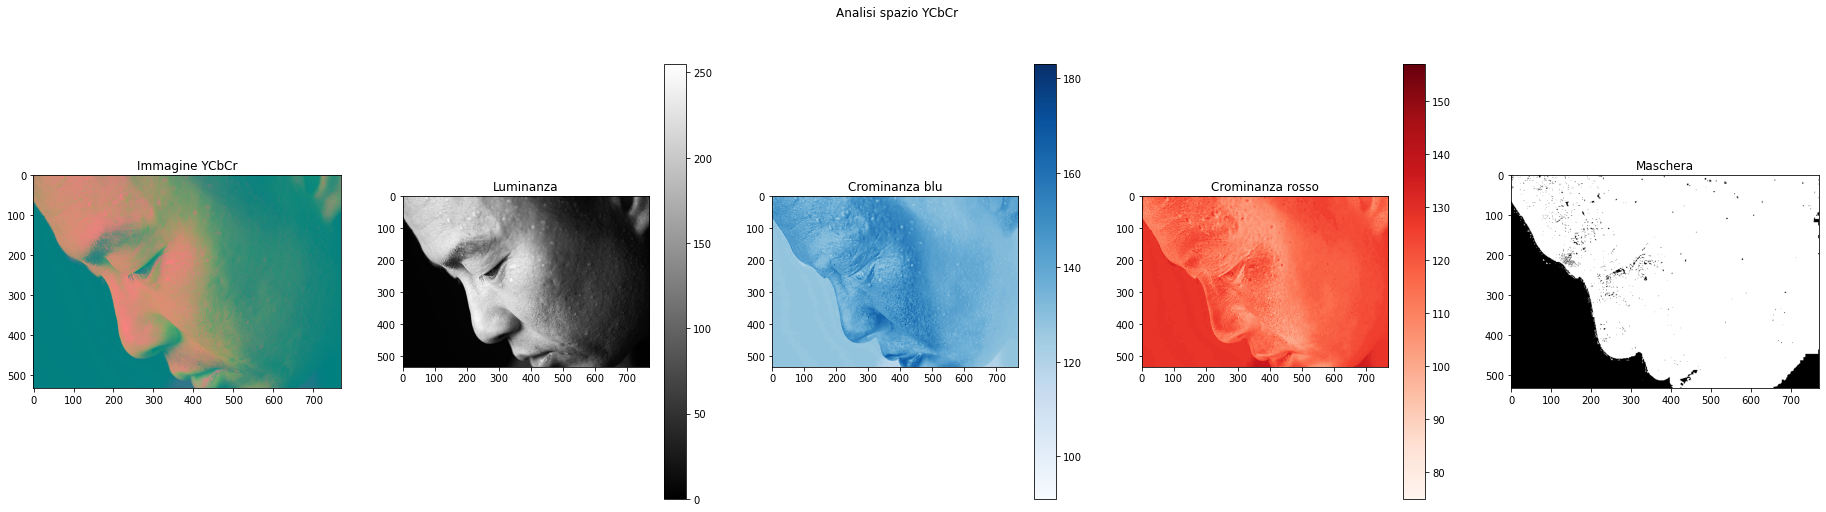

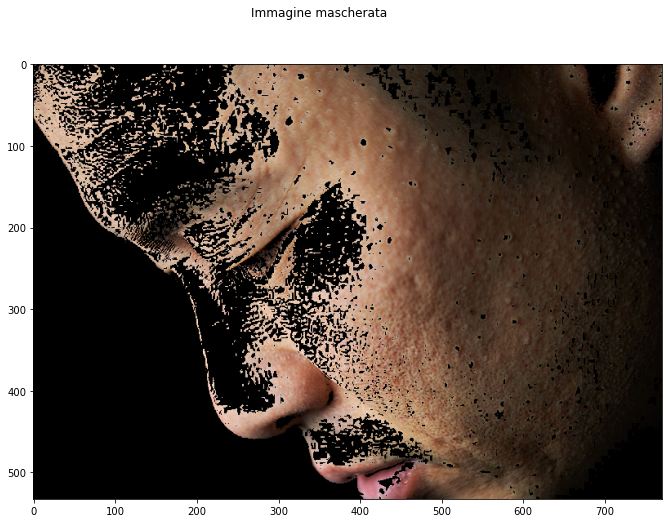

In [26]:
run_analysis('/manSweatingCloseup.jpg')

Salta subito all'occhio come le zone più problematiche per l'immagine siano quelle ad alta illuminazione (bassa saturazione, basso rapporto R/G) e le goccioline di sudore che, avendo caratteristiche diverse dalla pelle per quando riguarda la "reazione" alla luce, si spostano fuori soglia.

Proviamo ora ad analizzare l'immagine della Gioconda.

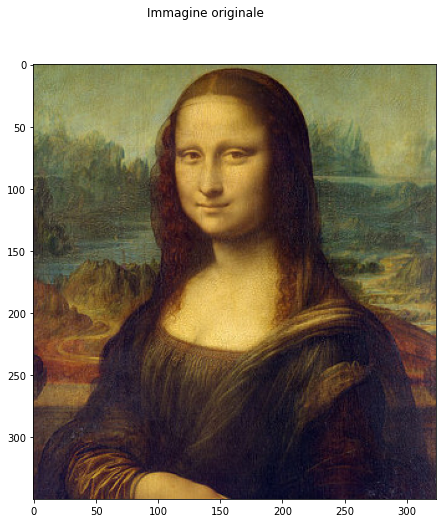

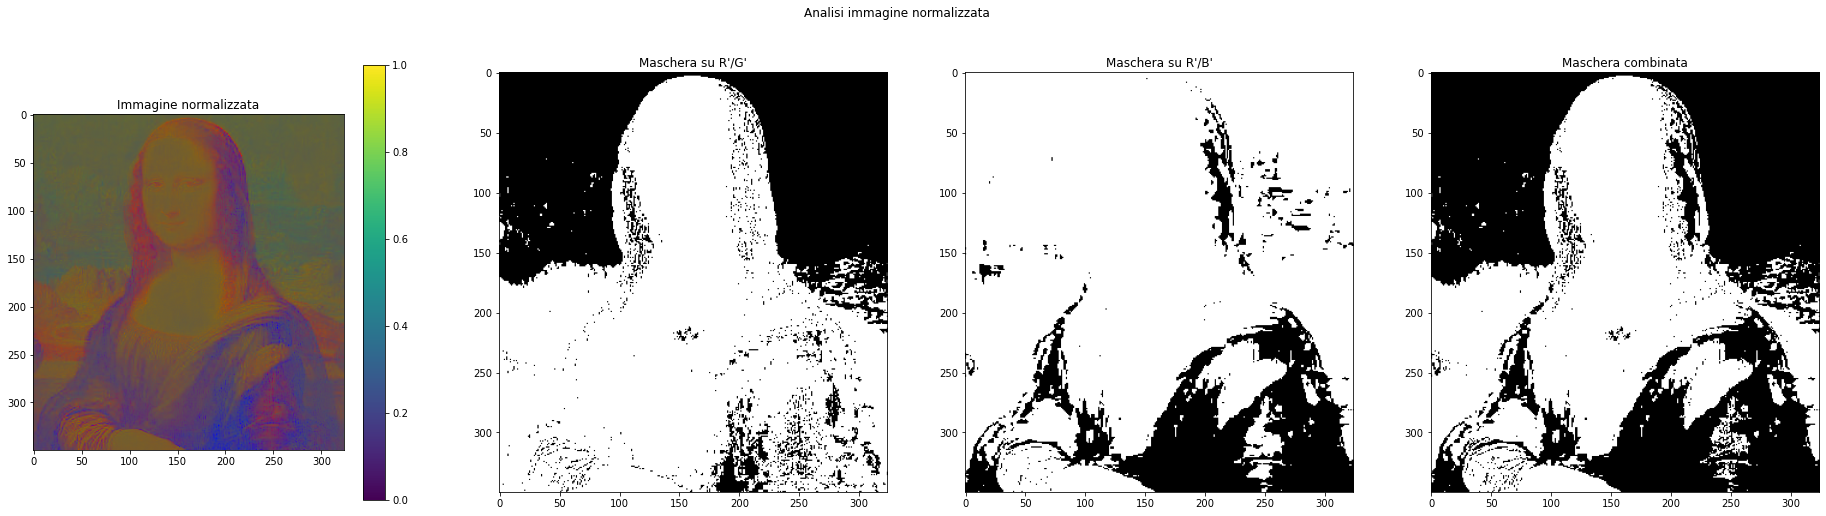

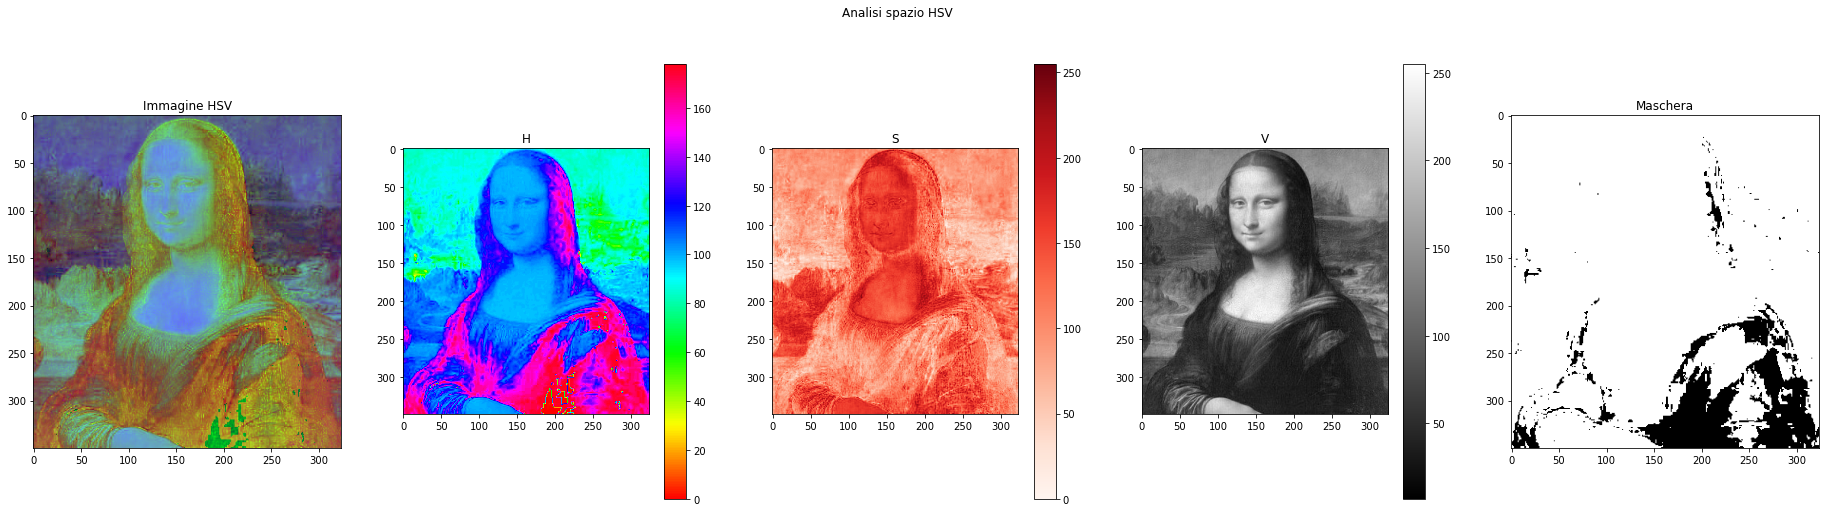

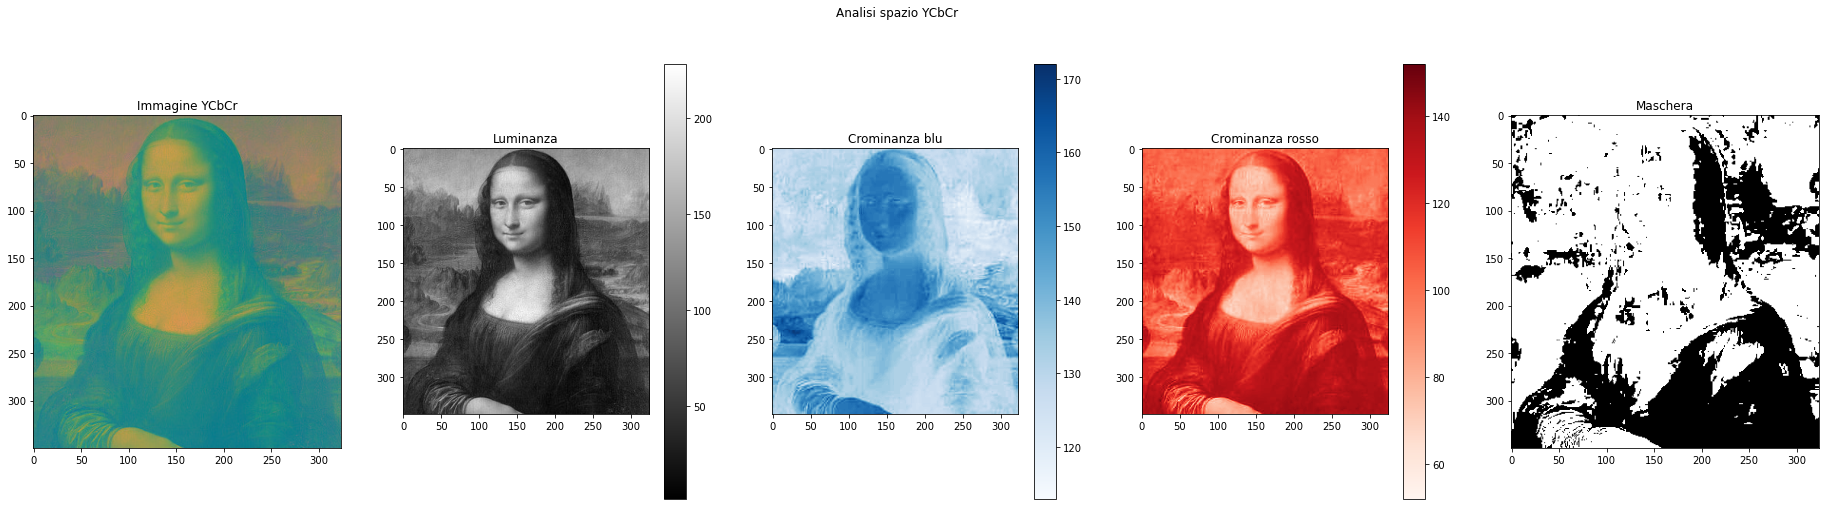

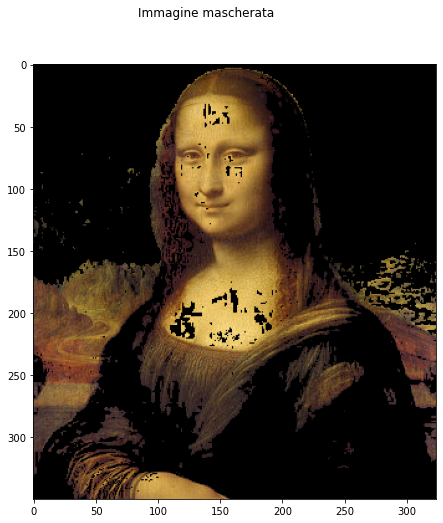

In [27]:
run_analysis("/gioconda.jpg")

Ad essere onesto, si tratta di un risultato migliore di quanto mi aspettassi.
Non essendo una foto di una persona "reale", ma un ritratto, non dovrebbe condividere tutte le caratteristiche delle foto della pelle.
Invece, nonostante ci siano problemi col background e coi vestiti, che stavolta sarebbero specificatamente risolvibili per questo immagine aggiungendo una sogliatura sulla luminosità, riusciamo ad individuare la pelle rappresentata nel dipinto.

Vediamo, infine, come si comporta l'algoritmo su immagini di bassa qualità

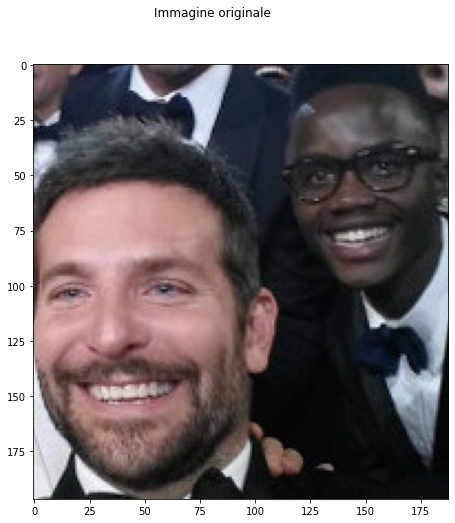

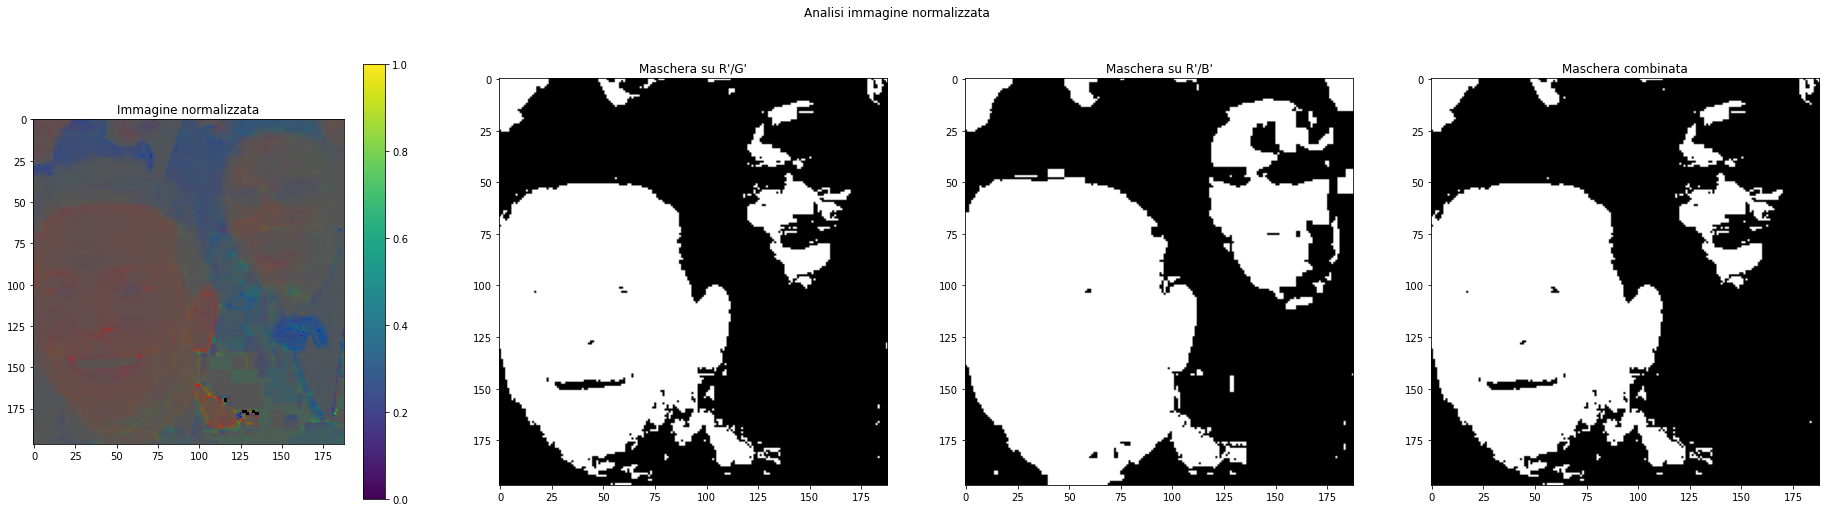

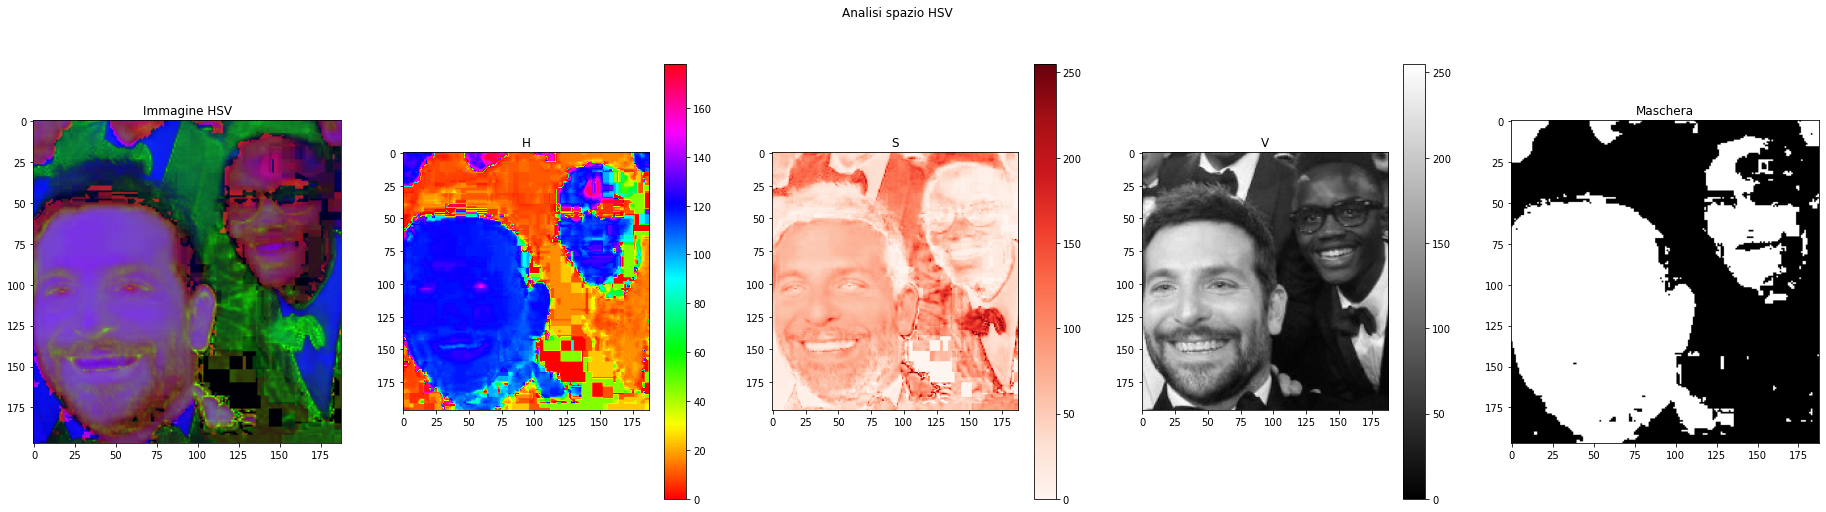

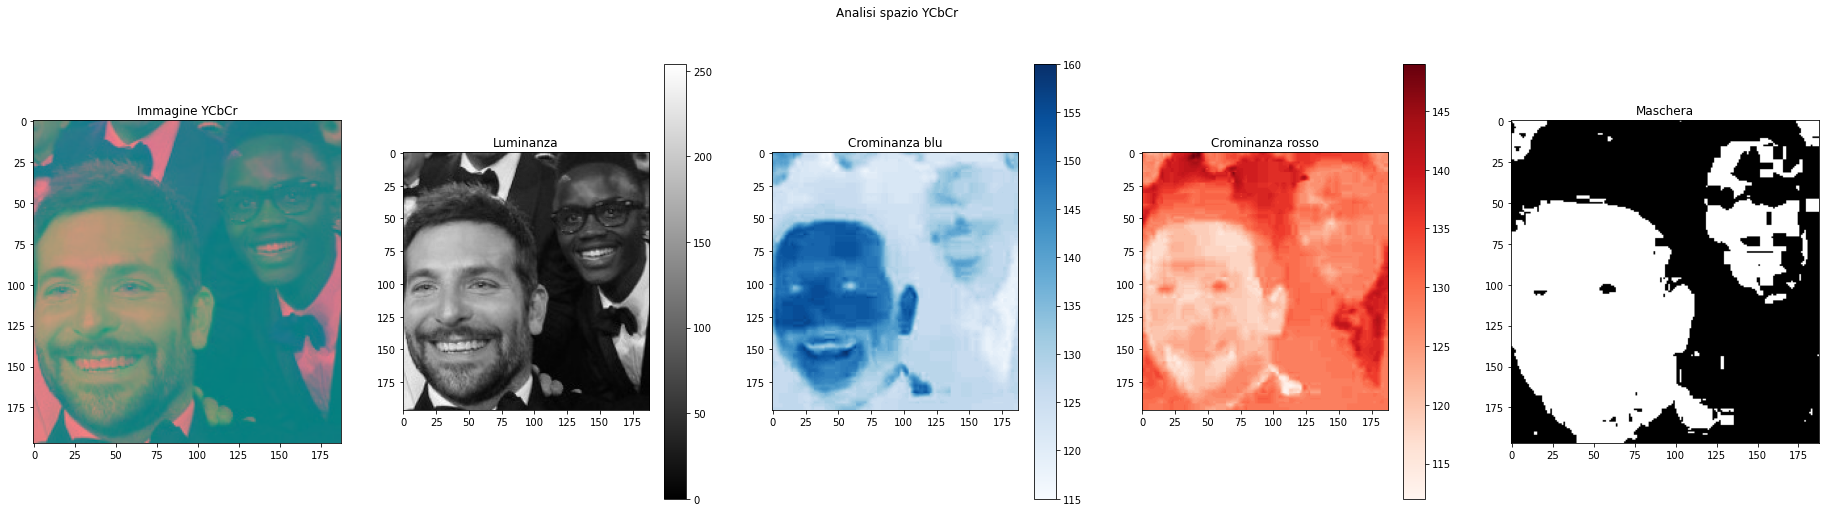

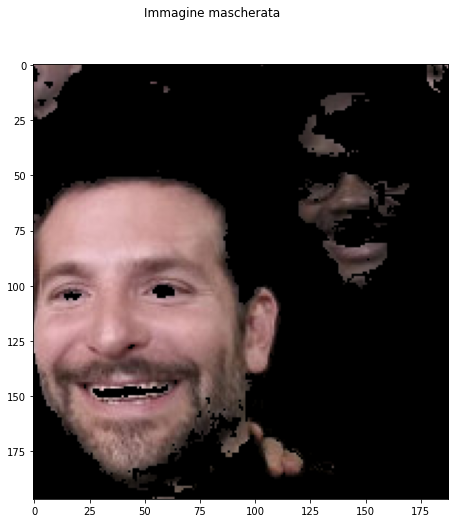

In [28]:
run_analysis("/BC.jpeg")

Il risultato è abbastanza disastroso.
Falliamo completamente nell'individuare una persona di colore.
Ma il problema non è tanto da ricercarsi nei valori di soglia, che funzionano perfettamente nella seconda immagine, quanto nella bassissima qualità della foto, che porta ad avere problemi di "stabilità" nei valori dell'immagine e nella conversione della stessa verso altri canali di colore

## Conclusioni

Il metodo, per quanto sia comunque abbastanza solido, ha delle pecche intrinseche che richiedono metodi di analisi più avanzati per ottenere risultati corretti in condizioni non ideali.

Resta comunque un ottimo metodo naïve per applicazioni che non richiedono precisione assoluta o con sogliature specifiche alle condizioni di applicazione (ad esempio, per immagini/video catturati in un ambiente controllato).


## Fonti

[Paper di riferimento (DOI: 10.1109/ICCOINS.2016.7783247)](https://ieeexplore.ieee.org/document/7783247)